In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
)

import tensorflow as tf
from tensorflow.keras import layers, models, Input

2021-11-13 10:59:01.197892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-13 10:59:01.197918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

In [3]:
x_train = np.load("./data/Xtrain_Classification_Part2.npy")
y_train = np.load("./data/Ytrain_Classification_Part2.npy")
# removed x_test,  loaded only on the final Testing steps

# Multi Layer Perpectron

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 2500)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              2501000   
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 4004      
Total params: 3,506,004
Trainable params: 3,506,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
295/295 [==============================] - 5s 15ms/step - loss: 1.0423 - accuracy: 0.6086 - val_loss: 0.8721 - val_accuracy: 0.6682
Epoch 2/20
295/295 [==============================] - 5s 15ms/step - loss: 0.8068 - accuracy: 0.696

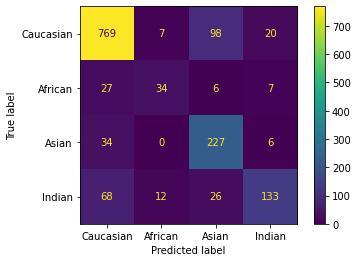

In [7]:
train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2)

train_y_cat = tf.keras.utils.to_categorical(train_y, 4)
test_y_cat = tf.keras.utils.to_categorical(test_y, 4)

# trainar o modelo:
# Input scaled from (0, 255) to a range of (0, +1.)
mlp = models.Sequential()
mlp.add(Input(shape=(2500,)))
mlp.add(layers.Rescaling(scale=1 / 255))  # scale 0-255 to 0-1
mlp.add(layers.Dense(1000, activation="relu"))
mlp.add(layers.Dense(1000, activation="relu"))
# if softmax is chosen, the model will have more parameters that need to learn
mlp.add(layers.Dense(4, activation="softmax"))  # output layer
mlp.summary()
mlp.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = mlp.fit(
    train_x, train_y_cat, epochs=20, batch_size=20, validation_data=(test_x, test_y_cat)
)

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

y_hat_test_cat = mlp.predict(test_x)
y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
# test_loss, test_acc = mlp.evaluate(test_x,  test_y, verbose=2)

ConfusionMatrixDisplay.from_predictions(
    test_y, y_hat_test, display_labels=["Caucasian", "African", "Asian", "Indian"]
)

bacc = balanced_accuracy_score(test_y, y_hat_test)

print("BACC(MLP):", bacc)
print("Y_hat shape:", y_hat_test.shape)

BACC = 0.809608093469514


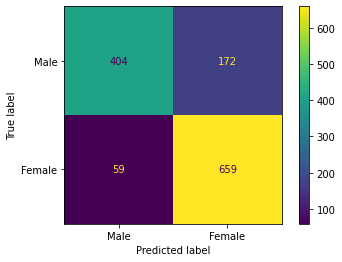

In [8]:
y_hat = (mlp.predict(test_x) > 0.5).astype("int32")
bacc = balanced_accuracy_score(test_y, y_hat)
ConfusionMatrixDisplay.from_predictions(
    test_y, y_hat, display_labels=["Male", "Female"]
)
print(f"BACC = {bacc}")

# Deep Neural Network

In [168]:
def make_model():
    model = models.Sequential()
    model.add(Input(shape=(50, 50, 1)))
    model.add(layers.Rescaling(scale=1 / 255))  # scale 0-255 to 0-1
    model.add(layers.Conv2D(12, (5, 5), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (5, 5), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    # Flatten
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation="softmax"))
    return model

t = make_model()
t.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_66 (Rescaling)     (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 46, 46, 12)        312       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 23, 23, 12)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 19, 19, 64)        19264     
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_66 (Flatten)         (None, 5184)            

In [150]:
# Callbacks, 
#   Earlystoping and
#   Learning Rate Scheduler

# learning step
def ln_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

ln_callback = tf.keras.callbacks.LearningRateScheduler(ln_scheduler)
# testar com outro monitor = "bacc"
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)  # restore_best_weights = False

### Train Test Split

In [161]:
train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2)

train_x = np.reshape(train_x, (len(train_x), 50, 50, 1))
test_x = np.reshape(test_x, (len(test_x), 50, 50, 1))

train_y_cat = tf.keras.utils.to_categorical(train_y, 4)
test_y_cat = tf.keras.utils.to_categorical(test_y, 4)

### Class weights and Data Augmentation

In [107]:
# imbalanced data class weights
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2, 3], y=y_train
)
class_weights = { c: w for c, w in enumerate(class_weight)}
print(class_weights)


{0: 0.4112326931665922, 1: 5.400293255131965, 2: 1.3763079222720478, 3: 1.5231596360628619}


In [126]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(50, 50, 1)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# Load some data
classes = 4

# Create a tf.data pipeline of augmented images (and their labels)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y_cat))
# train_dataset = train_dataset.batch(16).map(lambda x, y: (data_augmentation(x), y))

In [162]:
# Duplicate African Class Images with augmentation
africans = train_x[train_y==1]
africans_augmented = data_augmentation(africans)
# plt.imshow(africans_augmented[0])

train_x_plus_africans_augmented = np.append(train_x, africans_augmented, axis=0)
print(train_x.shape)
print(train_x_plus_africans_augmented.shape)

train_y_plus_africans_augmented = np.append(train_y, np.ones(len(africans_augmented)))
train_y_cat_plus_africans = tf.keras.utils.to_categorical(train_y_plus_africans_augmented, 4)

#class_weights_augmented = compute_class_weight(
#    class_weight="balanced", classes=[0, 1, 2, 3], y=y_train
#)


(5892, 50, 50, 1)
(6155, 50, 50, 1)


In [163]:
print(sum(train_y == 1))
print(sum(train_y_plus_africans_augmented == 1))
print(sum(test_y == 1))


263
526
78


## Train and Evaluate

Epoch 1/40
97/97 [==============================] - 7s 70ms/step - loss: 1.4174 - categorical_accuracy: 0.2478 - val_loss: 1.1658 - val_categorical_accuracy: 0.5075
Epoch 2/40
97/97 [==============================] - 7s 76ms/step - loss: 0.9263 - categorical_accuracy: 0.5971 - val_loss: 0.7455 - val_categorical_accuracy: 0.7429
Epoch 3/40
97/97 [==============================] - 7s 72ms/step - loss: 0.8047 - categorical_accuracy: 0.6725 - val_loss: 0.7884 - val_categorical_accuracy: 0.7198
Epoch 4/40
97/97 [==============================] - 8s 80ms/step - loss: 0.7549 - categorical_accuracy: 0.6923 - val_loss: 0.7619 - val_categorical_accuracy: 0.7049
Epoch 5/40
97/97 [==============================] - 8s 83ms/step - loss: 0.6608 - categorical_accuracy: 0.7241 - val_loss: 0.6373 - val_categorical_accuracy: 0.7680
Epoch 6/40
97/97 [==============================] - 8s 82ms/step - loss: 0.6093 - categorical_accuracy: 0.7423 - val_loss: 0.7031 - val_categorical_accuracy: 0.7320
Epoch 7/40

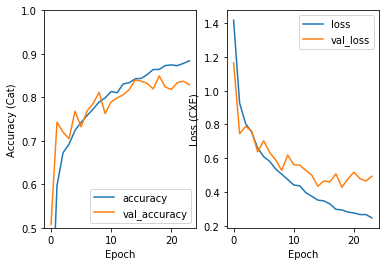

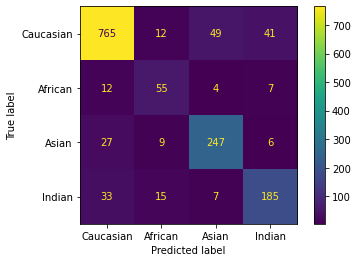

In [164]:
# Generate the model:
model = make_model()
model.compile(
   optimizer="adam",
   loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

## baseline
# history = model.fit(
#     train_x,
#     train_y_cat,
#     epochs=40,
#     batch_size=32,
#     validation_data=(test_x, test_y_cat),
#     callbacks=[earlystop, ln_callback],
#     class_weight=class_weights,
# )

# augmented african class
history = model.fit(
    train_x_plus_africans_augmented,
    train_y_cat_plus_africans,
    epochs=40,
    batch_size=64,
    validation_data=(test_x, test_y_cat),
    callbacks=[earlystop, ln_callback],
    #callbacks=[earlystop],
    class_weight=class_weights
)


# Evaluate the model
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history["categorical_accuracy"], label="accuracy")
ax1.plot(history.history["val_categorical_accuracy"], label="val_accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (Cat)")
ax1.set_ylim([0.5, 1])
ax1.legend(loc="lower right")

ax2.plot(history.history["loss"], label="loss")
ax2.plot(history.history["val_loss"], label="val_loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss (CXE)")
ax2.legend(loc="upper right")

# test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=2)
# print(f"Test Loss: {test_loss:.3f} Test Accuracy {test_acc:.3f}")

y_hat_test_cat = model.predict(test_x)
y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
# test_loss, test_acc = mlp.evaluate(test_x,  test_y, verbose=2)

ConfusionMatrixDisplay.from_predictions(
    test_y, y_hat_test, display_labels=["Caucasian", "African", "Asian", "Indian"]
)

bacc = balanced_accuracy_score(test_y, y_hat_test)

print(f"BACC = {bacc:.3f}")
print("Y_hat shape:", y_hat_test.shape)


Epoch 1/20
93/93 [==============================] - 5s 55ms/step - loss: 1.1981 - categorical_accuracy: 0.4043 - val_loss: 1.1151 - val_categorical_accuracy: 0.5007
Epoch 2/20
93/93 [==============================] - 7s 76ms/step - loss: 0.8706 - categorical_accuracy: 0.6256 - val_loss: 0.7305 - val_categorical_accuracy: 0.7388
Epoch 3/20
93/93 [==============================] - 7s 74ms/step - loss: 0.7547 - categorical_accuracy: 0.6877 - val_loss: 0.8043 - val_categorical_accuracy: 0.6845
Epoch 4/20
93/93 [==============================] - 7s 75ms/step - loss: 0.6695 - categorical_accuracy: 0.7232 - val_loss: 0.6835 - val_categorical_accuracy: 0.7415
Epoch 5/20
93/93 [==============================] - 7s 75ms/step - loss: 0.6191 - categorical_accuracy: 0.7452 - val_loss: 0.7591 - val_categorical_accuracy: 0.6974
Epoch 6/20
93/93 [==============================] - 7s 75ms/step - loss: 0.5756 - categorical_accuracy: 0.7615 - val_loss: 0.5304 - val_categorical_accuracy: 0.8148
Epoch 7/20

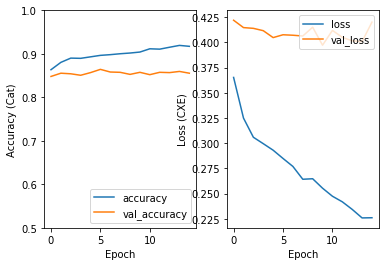

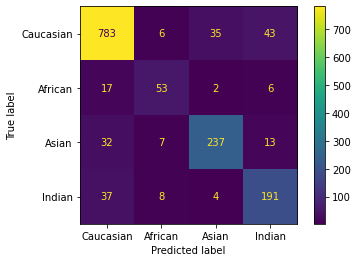

In [170]:
## Teste
# Generate the model:
model = make_model()
model.compile(
   optimizer="adam",
   loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

# # baseline
# history = model.fit(
#     train_x,
#     train_y_cat,
#     epochs=20,
#     batch_size=64,
#     validation_data=(test_x, test_y_cat),
#     callbacks=[earlystop, ln_callback],
#     class_weight=class_weights,
# )
# # Evaluate Base Line
# y_hat_test_cat = model.predict(test_x)
# y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
# bacc = balanced_accuracy_score(test_y, y_hat_test)
# print(f"BACC base_= {bacc:.3f}")

# augmented african class
history = model.fit(
    train_x_plus_africans_augmented,
    train_y_cat_plus_africans,
    epochs=40,
    batch_size=64,
    validation_data=(test_x, test_y_cat),
    callbacks=[earlystop, ln_callback],
    #callbacks=[earlystop],
    class_weight=class_weights
)


# Evaluate the model
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history["categorical_accuracy"], label="accuracy")
ax1.plot(history.history["val_categorical_accuracy"], label="val_accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (Cat)")
ax1.set_ylim([0.5, 1])
ax1.legend(loc="lower right")

ax2.plot(history.history["loss"], label="loss")
ax2.plot(history.history["val_loss"], label="val_loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss (CXE)")
ax2.legend(loc="upper right")

# test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=2)
# print(f"Test Loss: {test_loss:.3f} Test Accuracy {test_acc:.3f}")

y_hat_test_cat = model.predict(test_x)
y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
# test_loss, test_acc = mlp.evaluate(test_x,  test_y, verbose=2)

ConfusionMatrixDisplay.from_predictions(
    test_y, y_hat_test, display_labels=["Caucasian", "African", "Asian", "Indian"]
)

bacc = balanced_accuracy_score(test_y, y_hat_test)

print(f"BACC = {bacc:.3f}")
print("Y_hat shape:", y_hat_test.shape)


# Save / Load models

In [165]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_models
from time import time
NAME = "c2_12k5x5_64k5x5_d2_64_wc_africans_aug"
#NAME = "teste"

model.save(f"saved_models/{NAME}_{int(time())}.h5")


In [ ]:
loaded_model = tf.keras.models.load_model("saved_models/c2_12k5x5_64k5x5_d2_64.h5")

# Predição FINAL

In [ ]:
# NEVER CHANGE
Xtest_Classification_Part2 = np.load("./data/Xtest_Classification_Part2.npy")
Xtest_Classification_Part2_50_50 = np.reshape(Xtest_Classification_Part2, (len(Xtest_Classification_Part2),50, 50, 1))

print("Test input shape", Xtest_Classification_Part2_50_50.shape)
y_hat_test_cat = model.predict(Xtest_Classification_Part2_50_50)
y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
print("Test output shape", y_hat_test.shape)

# Save
np.save(f"y_hat_classification_prob2_{int(time())}.npy", y_hat_test)

In [ ]:
# Load and print shape
load_y_hat = np.load(f"y_hat_classification_prob2_111111111.npy")
print("Loaded array shape", load_y_hat.shape)
print("Loaded Bin count", np.bincount(load_y_hat))